## Importing libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import f1_score

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/My Drive/Data files for Colab/train.csv'
train = pd.read_csv(path)
train.drop('ID',inplace=True,axis=1)

Let us separate the feature and target matrix first. For features, we will only use the abstract based on the assumption that the title's words are largely paraphrased again in the abstract

In [4]:
labels = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [5]:
train['length'] = train['ABSTRACT'].apply(len)
train['total'] = train[labels].sum(axis=1)

## EDA

Majority of articles i.e. 40% belong to computer science followed by physics, mathematics and statistics between 20 to 30% of articles. Quantitative Biology and Quantiative Finance have fewer articles considering it is a niche field of study   

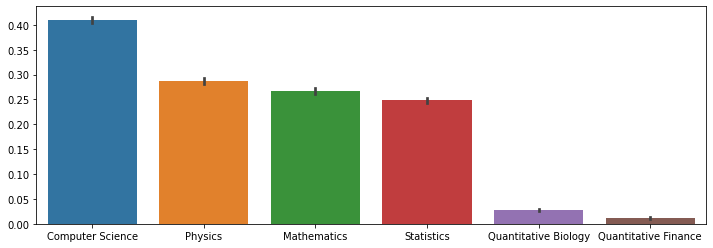

In [6]:
plt.figure(figsize=(12,4))
sns.barplot(data=train[labels]);

Majority of the articles i.e. 16k out of 20k entries belong to only one category whereas fewer have 2 and 3 categories attributed to it

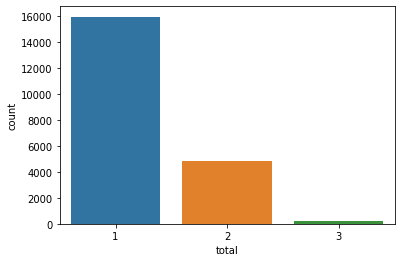

In [7]:
sns.countplot(train['total']);

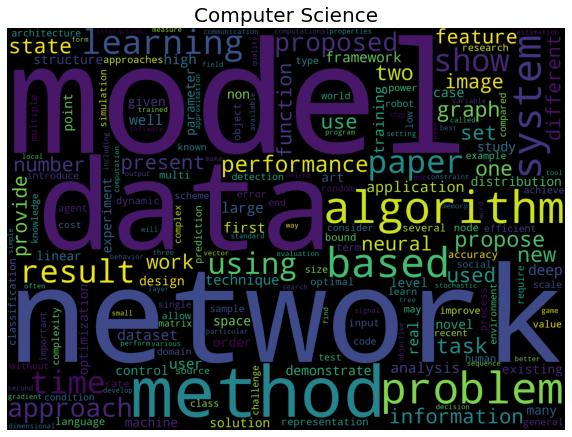

In [8]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(10,10))
subset = train[train['Computer Science']==True]
text = subset['ABSTRACT'].values
cloud_cs = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Computer Science",fontsize=20)
plt.imshow(cloud_cs);

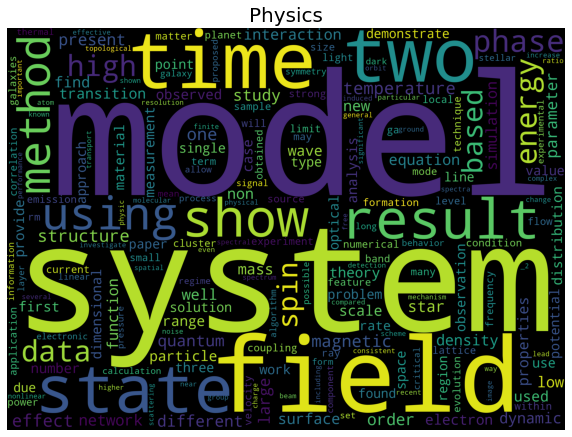

In [9]:
plt.figure(figsize=(10,10))
subset = train[train['Physics']==True]
text = subset['ABSTRACT'].values
cloud_phy = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Physics",fontsize=20)
plt.imshow(cloud_phy);

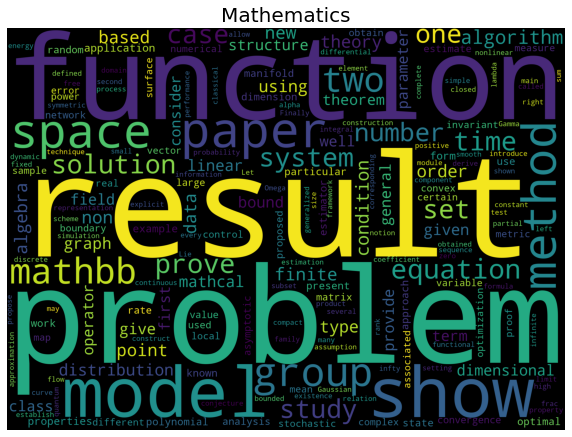

In [10]:
plt.figure(figsize=(10,10))
subset = train[train['Mathematics']==True]
text = subset['ABSTRACT'].values
cloud_math = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Mathematics",fontsize=20)
plt.imshow(cloud_math);

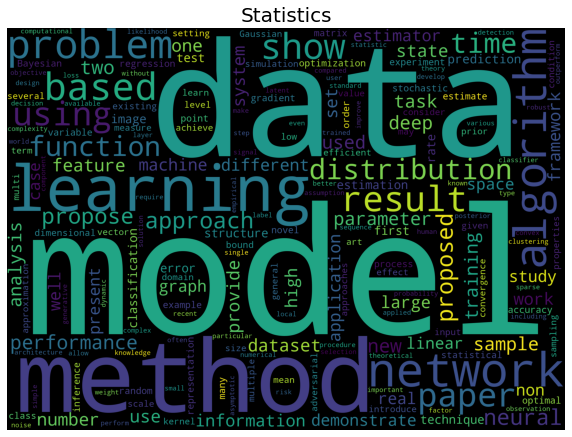

In [11]:
plt.figure(figsize=(10,10))
subset = train[train['Statistics']==True]
text = subset['ABSTRACT'].values
cloud_stat = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Statistics",fontsize=20)
plt.imshow(cloud_stat);

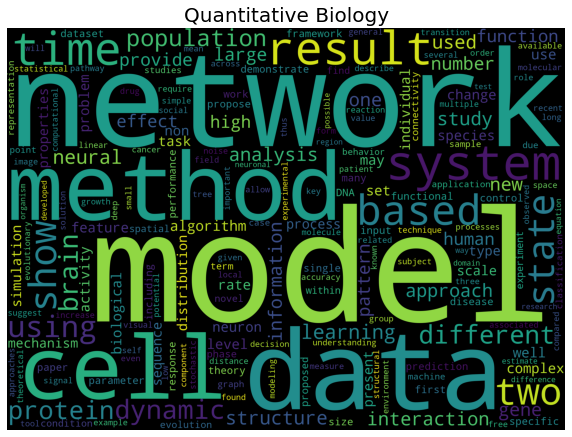

In [12]:
plt.figure(figsize=(10,10))
subset = train[train['Quantitative Biology']==True]
text = subset['ABSTRACT'].values
cloud_qtbio = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Quantitative Biology",fontsize=20)
plt.imshow(cloud_qtbio);

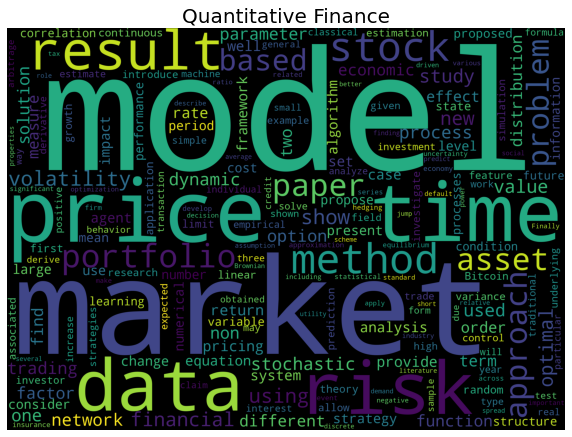

In [13]:
plt.figure(figsize=(10,10))
subset = train[train['Quantitative Finance']==True]
text = subset['ABSTRACT'].values
cloud_qtfin = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Quantitative Finance",fontsize=20)
plt.imshow(cloud_qtfin);

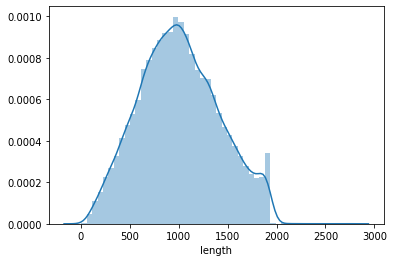

In [14]:
sns.distplot(train['length']);

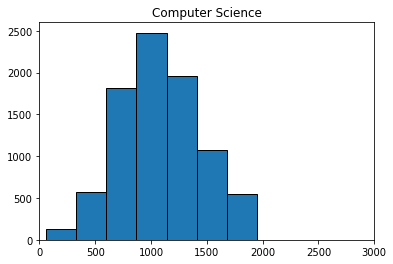

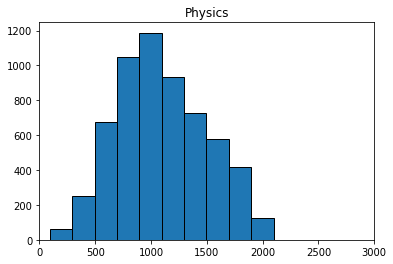

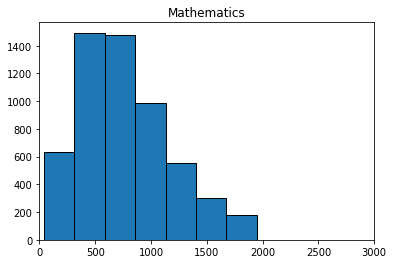

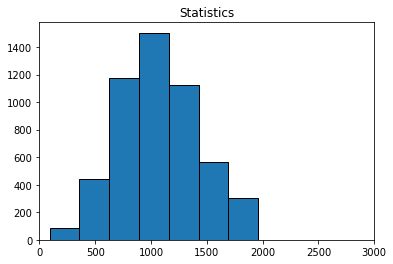

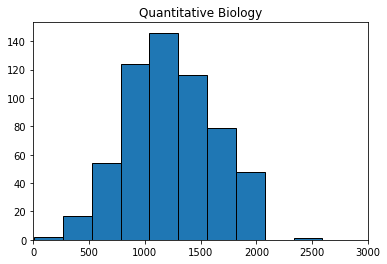

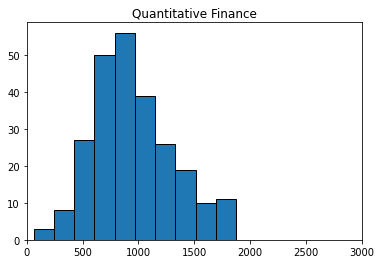

In [16]:
for i in labels:
    plt.hist(train[train[i]==1]['length'],label=i,edgecolor='black')
    plt.xlim(0,3000)
    plt.title(i)
    plt.show()

## Doubling the observations for category 5 and 6 to improve model recall later while training  

In [17]:
y = train[labels].values

In [18]:
cat5 = []
cat6 = []
for i in range(0,len(y)):
  if y[i][4]==1:
    cat5.append(i) 
  if y[i][5]==1:
    cat6.append(i)

In [19]:
#Let us double the entries from category 5 and category 6 i.e. quantitative biology and quantiative finance to improve model recall
for i in cat5:
  train = pd.concat([train,pd.DataFrame(train.iloc[i]).transpose()])

In [20]:
for i in cat6:
  train = pd.concat([train,pd.DataFrame(train.iloc[i]).transpose()])

In [21]:
train.shape

(21808, 10)

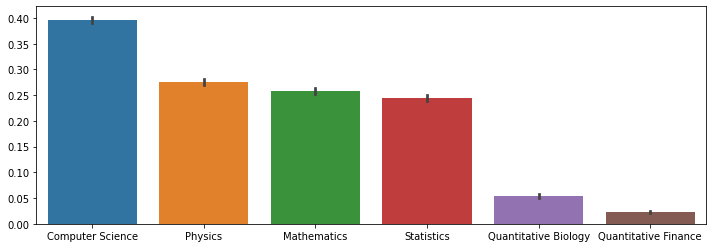

In [22]:
plt.figure(figsize=(12,4))
sns.barplot(data=train[labels]);

In [23]:
train.reset_index(drop=True,inplace=True)

In [24]:
X = train[['ABSTRACT','length']]
y = train [labels].values

In [25]:
X.tail()

,ABSTRACT,length
21803,"Aiming at financial applications, we study the problem of learning the\nvolatility under market microstructure noise. Specifically, we consider noisy\ndiscrete time observations from a stochastic differential equation and develop\na novel computational method to learn the diffusion coefficient of the\nequation. We take a nonparametric Bayesian approach, where we model the\nvolatility function a priori as piecewise constant. Its prior is specified via\nthe inverse Gamma Markov chain. Sampling from the posterior is accomplished by\nincorporating the Forward Filtering Backward Simulation algorithm in the Gibbs\nsampler. Good performance of the method is demonstrated on two representative\nsynthetic data examples. Finally, we apply the method on the EUR/USD exchange\nrate dataset.\n",780
21804,"Given a finite honest time, we derive representations for the additive and\nmultiplicative decomposition of it's Azéma supermartingale in terms of\noptional supermartingales and its running supremum. We then extend the notion\nof semimartingales of class-$(\Sigma)$ to optional semimartingales with jumps\nin its finite variation part, allowing one to establish formulas similar to the\nMadan-Roynette-Yor option pricing formulas for larger class of processes.\nFinally, we introduce the optional multiplicative systems associated with\npositive submartingales and apply them to construct random times with given\nAzéma supermartingale.\n",631
21805,"We study how shocks to the forward-looking expectations of investors buying\ncall and put options transmit across the financial system. We introduce a new\ncontagion measure, called asymmetric fear connectedness (AFC), which captures\nthe information related to ""fear"" on the two sides of the options market and\ncan be used as a forward-looking systemic risk monitoring tool. The decomposed\nconnectedness measures provide timely predictive information for near-future\nmacroeconomic conditions and uncertainty indicators, and they contain\nadditional valuable information that is not included in the aggregate\nconnectedness measure. The role of a positive/negative ""fear""\ntransmitter/receiver emerges clearly when we focus more closely on\nidiosyncratic events for financial institutions. We identify banks that are\npredominantly positive/negative receivers of ""fear"", as well as banks that\npositively/negatively transmit ""fear"" in the financial system.\n",950
21806,Risk diversification is one of the dominant concerns for portfolio managers.\nVarious portfolio constructions have been proposed to minimize the risk of the\nportfolio under some constrains including expected returns. We propose a\nportfolio construction method that incorporates the complex valued principal\ncomponent analysis into the risk diversification portfolio construction. The\nproposed method is verified to outperform the conventional risk parity and risk\ndiversification portfolio constructions.\n,506
21807,"Using a large-scale Deep Learning approach applied to a high-frequency\ndatabase containing billions of electronic market quotes and transactions for\nUS equities, we uncover nonparametric evidence for the existence of a universal\nand stationary price formation mechanism relating the dynamics of supply and\ndemand for a stock, as revealed through the order book, to subsequent\nvariations in its market price. We assess the model by testing its\nout-of-sample predictions for the direction of price moves given the history of\nprice and order flow, across a wide range of stocks and time periods. The\nuniversal price formation model is shown to exhibit a remarkably stable\nout-of-sample prediction accuracy across time, for a wide range of stocks from\ndifferent sectors. Interestingly, these results also hold for stocks which are\nnot part of the training sample, showing that the relations captured by the\nmodel are universal and not asset-specific.\nThe universal model --- trained on data from all stocks ---

## Pre-processing the text data

In [26]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
corpus = []
for i in range(0, len(X)):
    #Removing punctuations
    abstract = re.sub('[^a-zA-Z]', ' ', X['ABSTRACT'][i]) #replacing punctuations with blank space
    
    #Converting all to lower case letters 
    abstract = abstract.lower() #converting all words to lower case
    abstract = abstract.split()

    #Stemming and removing stopwords
    #ps = PorterStemmer() 
    #abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))] #stemming words

    #Lemmatization and removing stopwords
    wordnet_lemmatizer = WordNetLemmatizer()
    abstract = [wordnet_lemmatizer.lemmatize(word) for word in abstract if not word in set(stopwords.words('english'))] #lemmitizing words

    #Joining the words back to form a paragraph 
    abstract = ' '.join(abstract)
    corpus.append(abstract)

In [28]:
corpus[0] #lemmitized output

'predictive model allow subject specific inference analyzing disease related alteration neuroimaging data given subject data inference made two level global e identifiying condition presence subject local e detecting condition effect individual measurement extracted subject data global inference widely used local inference used form subject specific effect map rarely used existing model often yield noisy detection composed dispersed isolated island article propose reconstruction method named rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise due sampling error associated using finite sample example train classifier proposed method wrapper type algorithm used different binary classifier diagnostic manner e without information condition presence reconstruction posed maximum posteriori problem prior model whose parameter estimated training data classifier specific fashion experimental evaluation performed synt

In [ ]:
corpus[0] #stemmed output

'predict model allow subject specif infer analyz diseas relat alter neuroimag data given subject data infer made two level global e identifiy condit presenc subject local e detect condit effect individu measur extract subject data global infer wide use local infer use form subject specif effect map rare use exist model often yield noisi detect compos dispers isol island articl propos reconstruct method name rsm improv subject specif detect predict model approach particular binari classifi rsm specif aim reduc nois due sampl error associ use finit sampl exampl train classifi propos method wrapper type algorithm use differ binari classifi diagnost manner e without inform condit presenc reconstruct pose maximum posteriori problem prior model whose paramet estim train data classifi specif fashion experiment evalu perform synthet gener data data alzheim diseas neuroimag initi adni databas result synthet data demonstr use rsm yield higher detect accuraci compar use model directli bootstrap a

## Vectorization - Creating bag of words model

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.pipeline import Pipeline

# pipe = Pipeline([('count', CountVectorizer(max_features = 5000,ngram_range=(1,3))),('tfid', TfidfTransformer())])
# X = pipe.fit_transform(corpus).toarray()

cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [30]:
X.shape

(21808, 5000)

## Adding features to BOW array

In [31]:
#Separating the length variable from original train df to an array 
length = train['length'].values
length.shape

#Converting 1D to 2D array
new_len = np.reshape(length, (-1, 1))
new_len.shape

#Scaling all length values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_len = sc.fit_transform(new_len)

#Appending the new scaled length array to BOW array
X = np.append(X,new_len,axis=1)
X.shape

(21808, 5001)

## Splitting the data 

In [32]:
#convering all dtypes to float for running dl model later  
X = np.array(X, dtype=np.float)
y = np.array(y, dtype=np.float)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

## Building the model

In [34]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train))
print(type(y_train))

(17446, 5001)
(17446, 6)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [31]:
# from sklearn.metrics import f1_score, accuracy_score
# # using classifier chains
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import RandomForestClassifier


# # initialize classifier chains multi-label classifier
# # with a gaussian naive bayes base classifier
# rfc = MultiOutputClassifier(RandomForestClassifier())

# # train
# rfc.fit(X_train, y_train)

# # predict
# rfc_predictions = rfc.predict(X_test)

# print('RFC',f1_score(y_test,rfc_predictions,average='micro'))

RFC 0.7959163044576973


In [32]:
# # LGBM classifier
# from lightgbm import LGBMClassifier

# lgb = MultiOutputClassifier(LGBMClassifier())
# lgb.fit(X_train,y_train)
# lgb_predictions = lgb.predict(X_test)
# print('LGB',f1_score(y_test,lgb_predictions,average='micro'))

LGB 0.8070175438596492


In [84]:
#Deep learning model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout


dl_model = Sequential()

# Reference - https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

dl_model.add(Dense(5001,activation='relu'))
dl_model.add(Dropout(0.5))

dl_model.add(Dense(2504,activation='relu'))
dl_model.add(Dropout(0.5))

# dl_model.add(Dense(1255,activation='relu'))
# dl_model.add(Dropout(0.5))

# dl_model.add(Dense(50,activation='relu'))
# dl_model.add(Dropout(0.5))

dl_model.add(Dense(6,activation='sigmoid'))

# Remember to compile()

dl_model.compile(optimizer='adam',loss='binary_crossentropy')

In [85]:
dl_model.fit(x=X_train,y=y_train,validation_data=(X_test, y_test),epochs=1)

546/546 [==============================] - 97s 178ms/step - loss: 0.2238 - val_loss: 0.1832


In [86]:
losses = pd.DataFrame(dl_model.history.history)
losses

,loss,val_loss
0,0.223775,0.183194


In [97]:
dl_predictions = dl_model.predict(X_test)
dl_predictions[dl_predictions>=0.47] = int(1)
dl_predictions[dl_predictions<0.47] = int(0)
print('DL model',f1_score(y_test,dl_predictions,average='micro'))

DL model 0.8279920333152272


In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_test,dl_predictions))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1746
           1       0.93      0.85      0.89      1196
           2       0.76      0.85      0.81      1134
           3       0.77      0.75      0.76      1060
           4       0.83      0.71      0.77       227
           5       0.94      0.78      0.86        87

   micro avg       0.82      0.84      0.83      5450
   macro avg       0.84      0.81      0.82      5450
weighted avg       0.82      0.84      0.83      5450
 samples avg       0.85      0.87      0.84      5450



In [96]:
thresh = {}
for i in range(30,50):
  i=i/100
  dl_predictions = dl_model.predict(X_test)
  dl_predictions[dl_predictions>=i] = int(1)
  dl_predictions[dl_predictions<i] = int(0)
  thresh[i] = f1_score(y_test,dl_predictions,average='micro')
  print(i,f1_score(y_test,dl_predictions,average='micro'))

0.3 0.8146369732593758
0.31 0.8161703543503577
0.32 0.8183338909334225
0.33 0.8187626092804305
0.34 0.8207164582629267
0.35 0.8228289529641917
0.36 0.8241730062398497
0.37 0.8238831615120275
0.38 0.8249698223831695
0.39 0.8265880925556808
0.4 0.8273519163763066
0.41 0.8282563025210085
0.42 0.8281511494759095
0.43 0.8273113708820404
0.44 0.8264315611363433
0.45 0.8269695072878478
0.46 0.8275366226296397
0.47 0.8279920333152272
0.48 0.8279501410244745
0.49 0.8271254690216894


## Final model trained on entire dataset

In [ ]:
# model = MultiOutputClassifier(LGBMClassifier())
# model.fit(X,y)

## Predicting test results

In [41]:
test_df = pd.read_csv('/content/drive/My Drive/Data files for Colab/test.csv')

In [42]:
test_df.shape

(8989, 3)

In [43]:
test_df.drop(['ID','TITLE'],inplace=True,axis=1)
test_df['length'] = train['ABSTRACT'].apply(len)
test_length = test_df['length'].values
test_length = np.reshape(test_length, (-1, 1))
test_length = sc.transform(test_length)

In [44]:
test_corpus = []
for i in range(0, len(test_df)):
    #Removing punctuations
    abstract = re.sub('[^a-zA-Z]', ' ', test_df['ABSTRACT'][i]) #replacing punctuations with blank space
    
    #Converting all to lower case letters 
    abstract = abstract.lower() #converting all words to lower case
    abstract = abstract.split()

    #Stemming and removing stopwords
    #ps = PorterStemmer() 
    #abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))] #stemming words

    #Lemmatization and removing stopwords
    wordnet_lemmatizer = WordNetLemmatizer()
    abstract = [wordnet_lemmatizer.lemmatize(word) for word in abstract if not word in set(stopwords.words('english'))] #lemmitizing words

    #Joining the words back to form a paragraph 
    abstract = ' '.join(abstract)
    test_corpus.append(abstract)

In [45]:
test = cv.transform(test_corpus).toarray()
test = np.append(test,test_length,axis=1)
test.shape

(8989, 5001)

In [99]:
submission = dl_model.predict(test)
submission

array([[5.5990207e-01, 5.9187412e-03, 3.2062244e-01, 8.8312501e-01,
        2.3105741e-04, 1.0410249e-03],
       [1.3914496e-02, 9.8244500e-01, 3.5957396e-03, 3.4129620e-03,
        5.6302000e-05, 1.0169179e-05],
       [9.5116735e-01, 1.6636550e-03, 7.3470205e-02, 2.9606789e-02,
        4.3854816e-05, 6.6060224e-05],
       ...,
       [2.9758751e-01, 2.8237909e-02, 1.2420118e-02, 3.3858192e-01,
        9.0153813e-01, 2.5176406e-03],
       [4.7538671e-01, 3.6872029e-03, 7.2706848e-02, 8.6105728e-01,
        4.1669264e-05, 2.4801493e-04],
       [4.4874322e-01, 1.1429164e-01, 5.1113719e-01, 9.0843081e-02,
        6.2221557e-02, 2.3359686e-02]], dtype=float32)

In [100]:
submission[submission>=0.47] = int(1)
submission[submission<0.47] = int(0)
submission

array([[1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [101]:
labels = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']
sub = pd.DataFrame(data=submission,columns=labels)
test_ids = np.arange(20973,29962)
sub['ID'] = test_ids
sub.shape

(8989, 7)

In [102]:
sub = sub[['ID','Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance']]

In [103]:
sub[labels] = sub[labels].astype('int')

In [104]:
sub.tail()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
8984,29957,1,0,0,0,0,0
8985,29958,1,0,1,0,0,0
8986,29959,0,0,0,0,1,0
8987,29960,1,0,0,1,0,0
8988,29961,0,0,1,0,0,0


In [105]:
sub.to_csv('submission_v10.csv',index=False)